##### Carico Librerie

In [ ]:
pip install --upgrade pydicom scikit-image nibabel scipy matplotlib numpy opencv-python

In [ ]:
pip install --upgrade pip

In [ ]:
pip install 

In [2]:
# Librerie necessarie
from glob import glob
import numpy as np
import matplotlib.pyplot as plt

import skimage.transform
import os
from scipy.ndimage import zoom
from skimage import exposure

import pydicom as dicom

import cv2

#### Classi Per il progetto

In [37]:
class Abstract_volum:
    def __init__(self, path):
        self.path = path
        self.img_vol_raw = None
        self.img_vol_ela = None

    def get_middle_slice(self, volum):
        return int(np.round(volum.shape[0]/2))

    def get_image_ela(self): 
        # print ('Middle slice image 1: ', mid_slice_1)
        fig = plt.figure(figsize=(4,4))
        a = fig.add_subplot(1,1,1)
        # print(self.get_middle_slice(self.img_vol_ela))
        # print(self.img_vol_raw [self.get_middle_slice(self.img_vol_raw), :, :])
        imgplot = plt.imshow(self.img_vol_ela [self.get_middle_slice(self.img_vol_ela), :, :], cmap = 'gray')

class MR(Abstract_volum):
    def __init__(self, path):
        super().__init__(path)

        img_vol = []
        for path, _, files in sorted(os.walk(self.path)): 
            for filename in (sorted(files)): 
                if filename.endswith (dcm_ext):
                    # print (filename)                                              # uncomment if you want see the name of the slice
                    img_dcm_std = dicom.dcmread(os.path.join(self.path,filename))   # Funzione che legge i file dato il percoso
                    img = img_dcm_std.pixel_array                                   # estraiamo la matrice dell'immagine
                    img_vol.append (img)                                            # aggiungo immagine al volume

        self.img_vol_raw = np.array (img_vol)

        z_space = img_dcm_std.SpacingBetweenSlices
        x_space = img_dcm_std.PixelSpacing [0]
        y_space = img_dcm_std.PixelSpacing [1]

        self.vox_dims = (x_space, y_space, z_space) # I vox dims non voglio che siano la attributi del volume

        self.img_vol_ela = self.img_vol_raw

    def reseampling(self):
        """
        RESEAMPLING DEI VOXEL
            1) Definisco il mio voxel target, hai due posibilità:
                - scegli arbitrariamente (come in questo caso)
                - Fai la media di tutti i voxel
            2) Calcolo il mio vettore di scala: semplicemnte il rapporto fra i miei vettori di scala: dim di partenza dei voxel/dim di target
            3) Funzione che modifica la foto secondo il vettore
        """
        target_resolution = (1, 1, 1)
        scale_vector = (self.vox_dims[0]/target_resolution[0], self.vox_dims[1]/target_resolution[1], self.vox_dims[2]/target_resolution[2])
        
        self.vox_dims = target_resolution
        self.img_vol_ela = skimage.transform.rescale(self.img_vol_ela, scale_vector, order=3, preserve_range=True,  mode='constant')    

    def resizing(self):
        """
        RESIZE DELL'IMMAGINE: devo fare uno zoom
            1) Definisco la dimesione target
            2) Definisco il fattore di scala
            3) Passo volume, vettore di scale e un ordine (nel reseampling viene fatta interpolazione):
                - order 3 if images are in grey scale
                - order 0 if images are binary scale

        Ho ottenuto immagini di dim uguali in tutte le direzioni
        """
        target_shape = [192, 192, 192] 
        factors_1 = (
                target_shape[0]/self.img_vol_ela.shape[0],
                target_shape[1]/self.img_vol_ela.shape[1], 
                target_shape[2]/self.img_vol_ela.shape[2]
                )

        # print(factors_1)

        self.img_vol_ela = zoom(self.img_vol_ela, factors_1, order=3, mode= 'nearest') 

    def standardization(self): # a me non sembra faccia un tubo
        img_o = np.float32(self.img_vol_ela.copy())
        m = np.mean(img_o)
        s = np.std(img_o)
        self.img_vol_ela = np.divide((img_o - m), s)       # return the normalize image

        # print((volums[0].img_vol_raw == normalized_img).all())

    def normalization(self):
        self.img_vol_ela = cv2.normalize(self.img_vol_ela, None, alpha = 0, beta = 255, norm_type = cv2.NORM_MINMAX, dtype = cv2.CV_8UC1)

    def equalizzazione(self):
        # eq_img_1 = cv2.equalizeHist(norm_image [volums[0].get_middle_slice(), :, :])      # equalizzazione dell'istogramma tradizionale (applicato a immagine complessiva) PEGGIORE
        clahe_img = cv2.createCLAHE (clipLimit = 2.0, tileGridSize = (8, 8))                # equalizzazione adattiva (algo clahe) MIGLIORE

        print(type(clahe_img.apply (self.img_vol_ela[1, :, :])))

        aux = np.empty(shape=(192, 192, 192))
        for i in range(192):
            aux[i,:,:] = clahe_img.apply(self.img_vol_ela[i, :, :])
        
        self.img_vol_ela = aux

    def pre_processing(self):
        self.reseampling()
        print("post reseampling: " + str(self.img_vol_ela.shape))
        self.resizing()
        print("post resizing: " + str(self.img_vol_ela.shape))
        self.standardization()
        print("post standardization: " + str(self.img_vol_ela.shape))
        self.normalization()
        print("post normalization: " + str(self.img_vol_ela.shape))
        self.equalizzazione()
        print("post equalizzazione: " + str(self.img_vol_ela.shape))

    def compare_images_pre_post_processing(self):   
        fig = plt.figure(figsize=(8,8))

        a = fig.add_subplot(1, 2, 1)
        imgplot = plt.imshow(self.img_vol_raw [(self.get_middle_slice(self.img_vol_raw)), :, :], cmap = 'gray')

        a = fig.add_subplot(1, 2, 2)
        imgplot = plt.imshow(self.img_vol_ela [(self.get_middle_slice(self.img_vol_ela)), :, :], cmap = 'gray')
 
    def __str__(self):
        return self.path + "\n" + str(self.vox_dims) + "\n" + str(self.img_vol_raw.shape) + "\n" + str(self.img_vol_ela.shape)

class Segmentation(Abstract_volum):
    def __init__(self, path):
        super().__init__(path)
        
        img_seg = [] 
        for path, _, files in sorted(os.walk(self.path)): 
            for filename in (sorted(files)): 
                if filename.endswith (img_ext):
                        # print (filename)                                              # uncomment if you want see the name of the slice
                        img = cv2.imread(os.path.join(self.path,filename))              # Funzione che legge i file dato il percoso
                        img_seg.append (img)                                            # aggiungo immagine al volume

        self.img_vol_raw = np.array (img_seg)

        self.img_vol_ela = self.img_vol_raw

    def resizing(self):
        """
        RESIZE DELL'IMMAGINE: devo fare uno zoom
        1) Definisco la dimesione target
        2) Definisco il fattore di scala
        3) Passo volume, vettore di scale e un ordine (nel reseampling viene fatta interpolazione):
                - order 3 if images are in grey scale
                - order 0 if images are binary scale

        Ho ottenuto immagini di dim uguali in tutte le direzioni
        """
        target_shape = [192, 192, 192, 3] 
        factors_1 = (
            target_shape[0]/self.img_vol_ela.shape[0],
            target_shape[1]/self.img_vol_ela.shape[1], 
            target_shape[2]/self.img_vol_ela.shape[2],
            target_shape[3]/self.img_vol_ela.shape[3]
        )

        print(factors_1)

        self.img_vol_ela = zoom(self.img_vol_ela, factors_1, order=0, mode= 'nearest') 

    def __str__(self):
        return self.path + "\n" + str(self.img_vol_ela.shape)   # + "\n" + str(self.img_vol_ela.shape)


#### Funzione di supporto

In [22]:
def create_volums(root, suff):
    '''
    Function that create return an array of MR (magnetic resonance) or Segmentation
    Given the path of the folder that contains the files
    '''
    paths = sorted(glob(os.path.join(root, "*", suff)))
    volums = []
    for path in paths:
        if suff[-8:] == "/Ground/":
            volum = Segmentation(path)
        else: 
            volum = MR(path)
        volums.append(volum)

    return volums

#### Pre-processing MR

In [42]:
# Creo MR:

root_MR = "/mnt/Volume/Mega/LaureaMagistrale/CorsiSemestre/PassionInAction/Progetto/Train_Sets/MR"
suff_InPhase = "T1DUAL/DICOM_anon/InPhase/"
suff_OutPhase = "T1DUAL/DICOM_anon/OutPhase/"
dcm_ext = '.dcm'

mrs = create_volums(root_MR, suff_InPhase) + create_volums(root_MR, suff_OutPhase)

"""
for volum in volums:
    print(volum)
    volums[i].pre_processing()
    print(volum)
"""

for i in range(1):
    print(mrs[i])
    mrs[i].pre_processing()
    print(mrs[i])

/mnt/Volume/Mega/LaureaMagistrale/CorsiSemestre/PassionInAction/Progetto/Train_Sets/MR/1/T1DUAL/DICOM_anon/InPhase/
('1.89453125', '1.89453125', '5.5')
(35, 256, 256)
(35, 256, 256)
post reseampling: (66, 485, 1408)
(2.909090909090909, 0.3958762886597938, 0.13636363636363635)
post resizing: (192, 192, 192)
post standardization: (192, 192, 192)
post normalization: (192, 192, 192)
<class 'numpy.ndarray'>
post equalizzazione: (192, 192, 192)
/mnt/Volume/Mega/LaureaMagistrale/CorsiSemestre/PassionInAction/Progetto/Train_Sets/MR/1/T1DUAL/DICOM_anon/InPhase/
(1, 1, 1)
(35, 256, 256)
(192, 192, 192)


#### Pre-processing Segmentazioni

/mnt/Volume/Mega/LaureaMagistrale/CorsiSemestre/PassionInAction/Progetto/Train_Sets/MR/1/T1DUAL/Ground/
(35, 256, 256, 3)
(5.485714285714286, 0.75, 0.75, 1.0)
/mnt/Volume/Mega/LaureaMagistrale/CorsiSemestre/PassionInAction/Progetto/Train_Sets/MR/1/T1DUAL/Ground/
(192, 192, 192, 3)


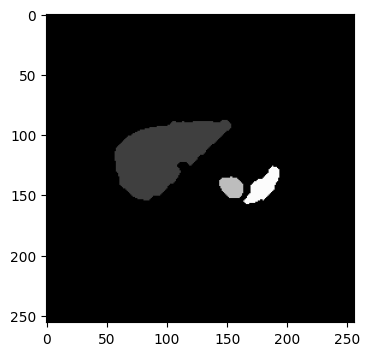

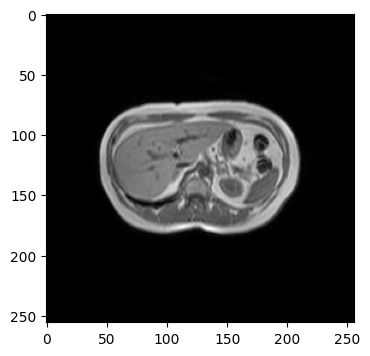

In [44]:
# Creo Segmentations

root_Seg = "/mnt/Volume/Mega/LaureaMagistrale/CorsiSemestre/PassionInAction/Progetto/Train_Sets/MR"
suff = "T1DUAL/Ground/"
img_ext = '.png'

segs = create_volums(root_Seg, suff)
"""
for volum in volums:
    print(volum)
    volum.reseampling()
    volum.resizing()
    print(volum)
"""

for i in range(1):
    print(str(segs[i]))
    segs[i].resizing()
    print(str(segs[i]))

segs[1].get_image_ela()
mrs[1].get_image_ela()

# Fai resize anche su segmentazione


# c'è file per range di pixel corrispondente ma tu portali a valori unici!


# riguarda lezione 8 alla fine per tutti i consigli!